In [14]:
import numpy as np
import json
import matplotlib.pyplot as plt 

In [15]:
with open("/home/jake/dev/alloc-bench-build/output-data/bdwgc-bintree-without-marktime.json") as f:
    data = json.load(f)
    hybrid = data["hybrid"]["binary_tree_profiling"]
    purecap = data["purecap"]["binary_tree_profiling"]

In [17]:
def process(frame):
    for k in frame:
        m, i, r = [seg[1:] for seg in k.split("-")]
        frame[k]["m"] = m
        frame[k]["i"] = i
        frame[k]["r"] = r
        frame[k]["pct-gc"] = (frame[k]["gc-time"] / frame[k]["total-time"])
        # frame[k]["pct-gc-mk"] = frame[k]["mark-time"] / frame[k]["gc-time"]
    return frame

hybrid = process(hybrid)
purecap = process(purecap)

In [18]:
def make_cluster_keys(frame):
    Is = sorted(set([frame[x]["i"] for x in frame]), key=int)
    rs = sorted(set([frame[x]["r"] for x in frame]), key=int)
    cluster_keys = [[f"m0-i{x}-r{r}" for r in rs] for x in Is]

    return (Is, rs, cluster_keys)

Is, rs, cluster_keys = make_cluster_keys(hybrid)

In [19]:
def makeNormalisedData(dataKey):
    return np.array([[hybrid[k][dataKey] / purecap[k][dataKey] for k in row] for row in cluster_keys])

In [20]:
# Your Data
def mkChart(data, title, measurement):
    # Number of bars in each cluster
    num_bars = len(data[0])
    # Positions of the bars on the x-axis
    x = np.arange(num_bars)
    
    # The width of the bars
    width = 1/(len(rs) + 1)
    
    # Create the plot
    fig, ax = plt.subplots()
    
    # Plotting the bars for each cluster
    offsets = [(i * width) - (width * (len(rs)-1) /2) for i in range(len(rs))]
    for r in range(len(rs)):
        offset = offsets[r]
        ax.bar(x + offset, data[r], width, label=f"r= {rs[r]}")
    
    # Adding labels and title
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel(measurement)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(Is)
    ax.legend()
    # Display the plot
    plt.show()
    fig.savefig(f"graphs/{title}.pdf")

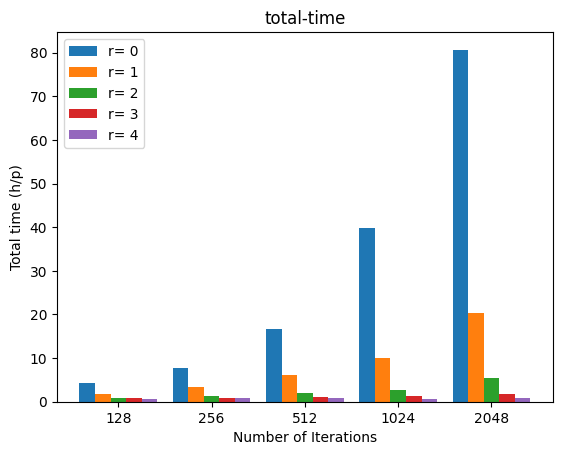

In [21]:
mkChart(makeNormalisedData("total-time").T, "total-time", "Total time (h/p)")

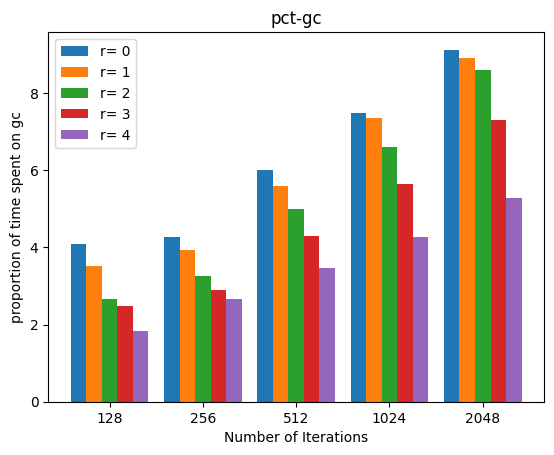

In [22]:
mkChart(makeNormalisedData("pct-gc").T, "pct-gc", "proportion of time spent on gc")

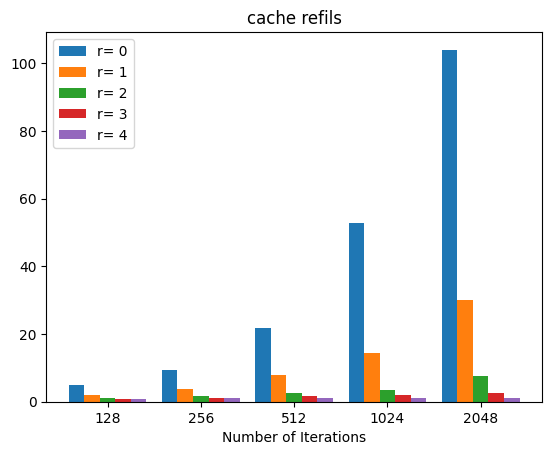

In [23]:
mkChart(makeNormalisedData("L2D_CACHE_REFILL").T, "cache refils", "")

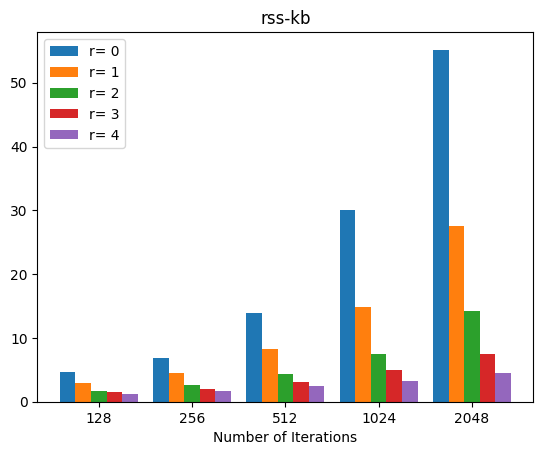

In [24]:
mkChart(makeNormalisedData("rss-kb").T, "rss-kb", "")